# 1. 对MNIST测试超过97%准确率

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X,y = mnist["data"],mnist["target"]
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [4]:
import datetime
s_time = datetime.datetime.now()

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, n_jobs=-1,cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 113.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [6]:
e_time = datetime.datetime.now()
print(e_time-s_time)

1:54:32.875000


In [7]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [8]:
grid_search.best_score_

0.9716166666666667

In [9]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

# 测试scipy.ndimage

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
some_digit = X[0]

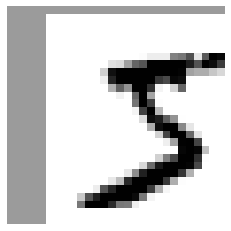

In [26]:
from scipy.ndimage.interpolation import shift

def shift_digit(digit_array, dx, dy, new=0):#为何【dy,dx】反着
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [28]:
import numpy as np
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [31]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [32]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [33]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9754

In [38]:
ambiguous_digit = X_test[213]
knn_clf.predict_proba([ambiguous_digit])

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

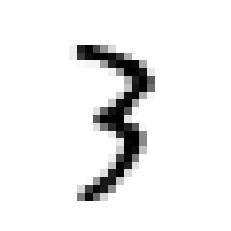

In [39]:
plot_digit(ambiguous_digit)

# 2. 训练集扩展

In [40]:
from scipy.ndimage.interpolation import shift

In [42]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])#转换成行

In [45]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_down.shape

(784,)

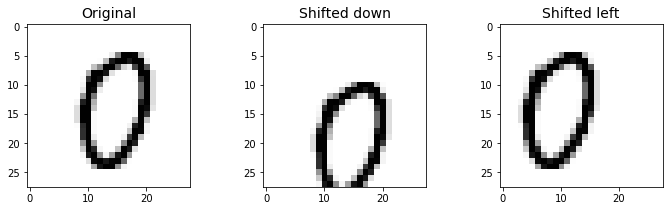

In [46]:
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [47]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [49]:
X_train_augmented.shape

(300000, 784)

In [50]:
shuffle_idx = np.random.permutation(len(X_train_augmented))#打散数据集，随机排列

In [54]:
shuffle_idx.shape

(300000,)

In [57]:
X_train_augmented = X_train_augmented[shuffle_idx]#打散数据集，随机排列
y_train_augmented = y_train_augmented[shuffle_idx]#打散数据集，随机排列

In [58]:
X_train_augmented.shape

(300000, 784)

In [59]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [60]:
s_time = datetime.datetime.now()
knn_clf.fit(X_train_augmented, y_train_augmented)
e_time = datetime.datetime.now()
print(e_time-s_time)

0:01:18.208000


In [61]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

##### 此处运行了较长时间，但是未打印时间

# 3. 泰坦尼克求生预测